# Calculate average dx and average dy for video of cells

Computes a dense optical flow using the Gunnar Farneback’s algorithm:

Gunnar Farneback, Two-frame motion estimation based on polynomial expansion, Lecture Notes in Computer Science, 2003, (2749), , 363-370.


Units of velocity are, I believe, Pixels/Frame.

In [1]:
import os
import fnmatch

import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
import pandas as pd

%pylab inline
    
def get_optical_flow_at_each_time(video_filename="data/07062016"):
    """ Given a video filename, return dx's and dy's for each time point"""
    mean_dxs = []
    mean_dys = []

    cap = cv2.VideoCapture(video_filename)

    ret, frame1 = cap.read()

    prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    while(True):
        ret, frame2 = cap.read()
        if not ret:
            break

        next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        prvs = next

        dx, dy = np.reshape(np.swapaxes(flow,0,2), (2, -1))

        mean_dxs.append(np.mean(dx))
        mean_dys.append(np.mean(dy))

    return mean_dxs, mean_dys

def plot_histogram(xs, ys, ticksize=12, fontsize=16, show=True):
    """ Plot a histogram given a numeric vector"""
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

    mpl.rc('font', **font)
    
    hist, bins = np.histogram(xs, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax1.bar(center, hist, align='center', width=width)
    ax1.text(0.55, 0.8,"mean: %.3f" % np.mean(xs), horizontalalignment='left',
             verticalalignment='center', transform = ax1.transAxes)
    ax1.text(0.55, 0.72,"stdev: %.3f" % np.std(xs), horizontalalignment='left',
         verticalalignment='center', transform = ax1.transAxes)
    ax1.set_xlabel("delta x", fontsize=fontsize)
    ax1.set_ylabel("Frequency", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=ticksize)
    
    hist, bins = np.histogram(ys, bins=10)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax2.bar(center, hist, align='center', width=width)
    ax2.text(0.55, 0.8,"mean: %.3f" % np.mean(ys), horizontalalignment='left',
             verticalalignment='center', transform = ax2.transAxes)
    ax2.text(0.55, 0.72,"stdev: %.3f" % np.std(ys), horizontalalignment='left',
         verticalalignment='center', transform = ax2.transAxes)
    ax2.set_xlabel("delta y", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=ticksize)

    if show:
        plt.show()
    return f

Populating the interactive namespace from numpy and matplotlib


## Here is an example histogram

I've increased the font sizes and shown the mean and stdev of the distribution.

/home/ubuntu/Desktop/cell_motion/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


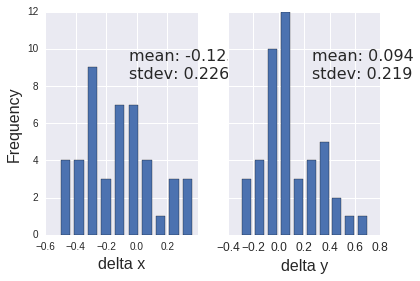

In [2]:
filepath = "data/06302016_Phagocytosis_DMSO.avi"
mean_dxs, mean_dys = get_optical_flow_at_each_time(filepath)
fig = plot_histogram(mean_dxs, mean_dys)

## Now lets calculate optical flow for each video and save histograms for each video

For each video.avi in `data/`, a corresponding histogram.png is plotted in `histograms/` with the same filename.

/home/ubuntu/Desktop/cell_motion/venv/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


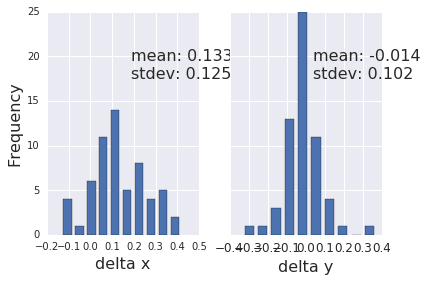

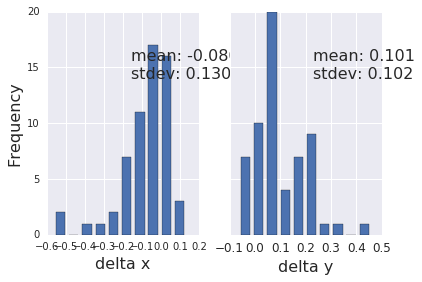

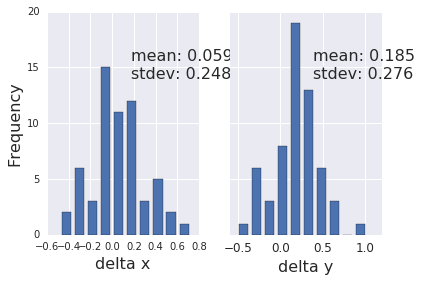

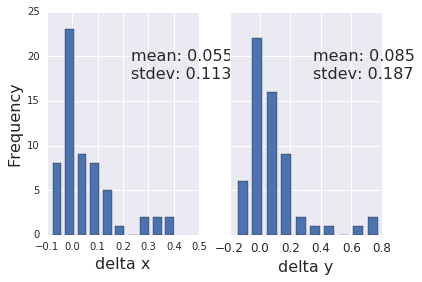

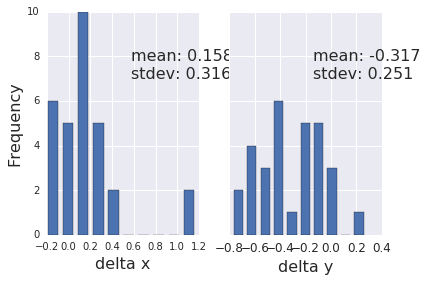

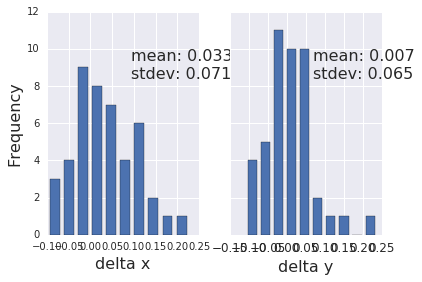

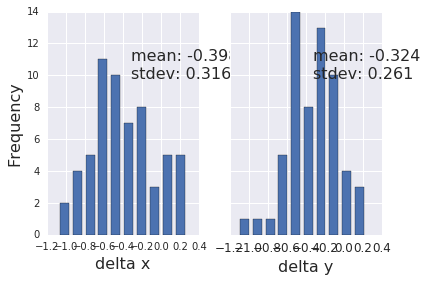

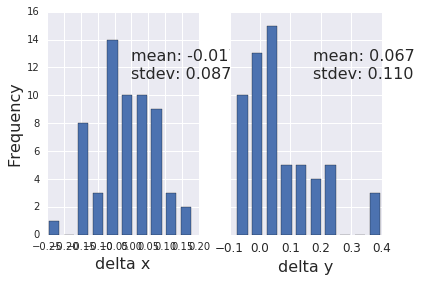

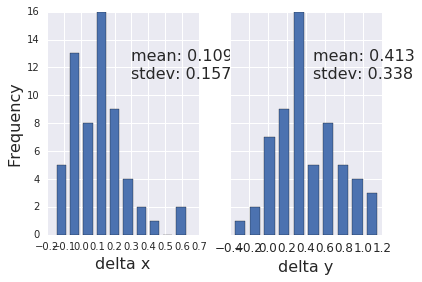

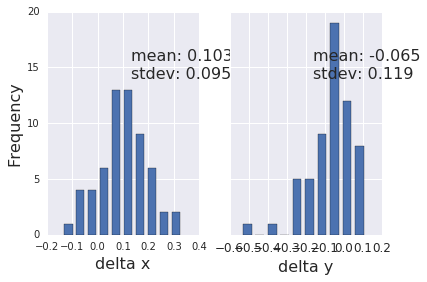

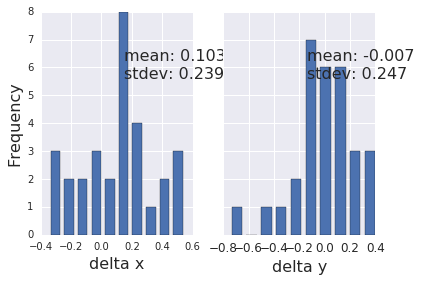

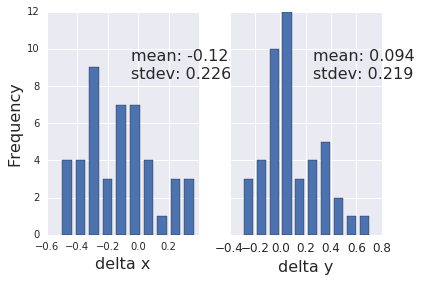

In [3]:
filenames = os.listdir("data/")
figure_format = ".png"

xs = []
ys = []
fnames = []
for filename in filenames:
    if fnmatch.fnmatch(filename, '*.avi'):
        mean_dxs, mean_dys = get_optical_flow_at_each_time("data/" + filename)
        xs.append(mean_dxs)
        ys.append(mean_dys)
        fnames.append(filename)
        fig = plot_histogram(mean_dxs, mean_dys, show=False)
        fig.savefig("histograms/" + os.path.splitext(filename)[0] + figure_format)
    

def order(l):
    return sorted(range(len(l)), key=lambda k: l[k])

ordered_files = order(fnames)
fnames = [fnames[i] for i in ordered_files]
xs = [xs[i] for i in ordered_files]
ys = [ys[i] for i in ordered_files]

## Now lets plot an set of 2d histograms/density-plots for easy viewing

the plots are in the same order as the list of files above:


In [4]:
fnames

['06302016_Phagocytosis_DMSO.avi',
 '06302016_Phagocytosis_Mrs2578.avi',
 '07052016_Phagocytosis_DMSO.avi',
 '07052016_Phagocytosis_MRS2578.avi',
 '07062016_Phagocytosis_DMSO.avi',
 '07062016_Phagocytosis_MRS2578.avi',
 '07072016_Phagocytosis_DMSO.avi',
 '07072016_Phagocytosis_MRS2578.avi',
 '08092016_Phagocytosis_DMSO.avi',
 '08092016_Phagocytosis_MRS2578.avi',
 '08172016_PMN_DMSO.avi',
 '08172016_PMN_MRS2578.avi']

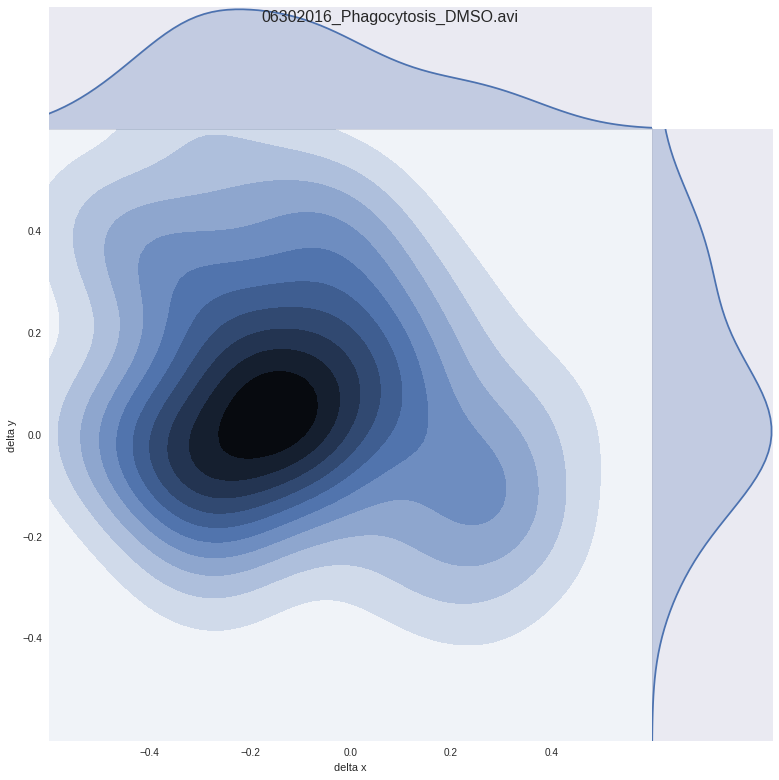

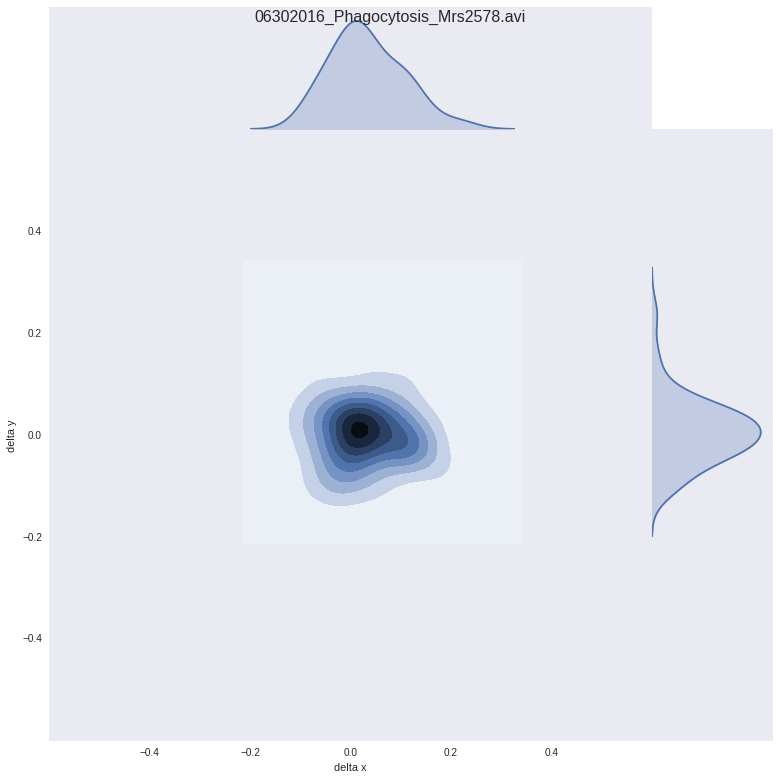

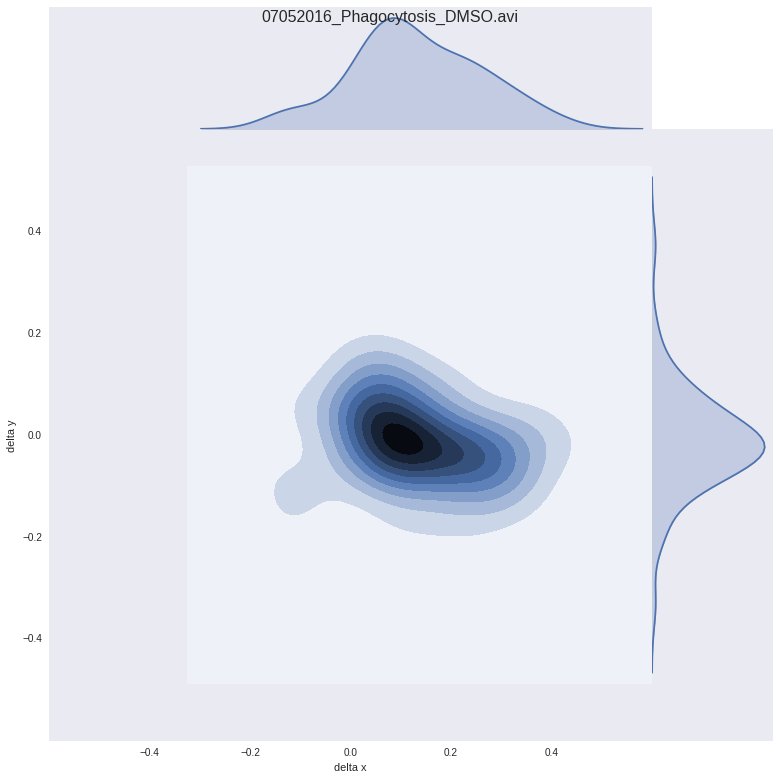

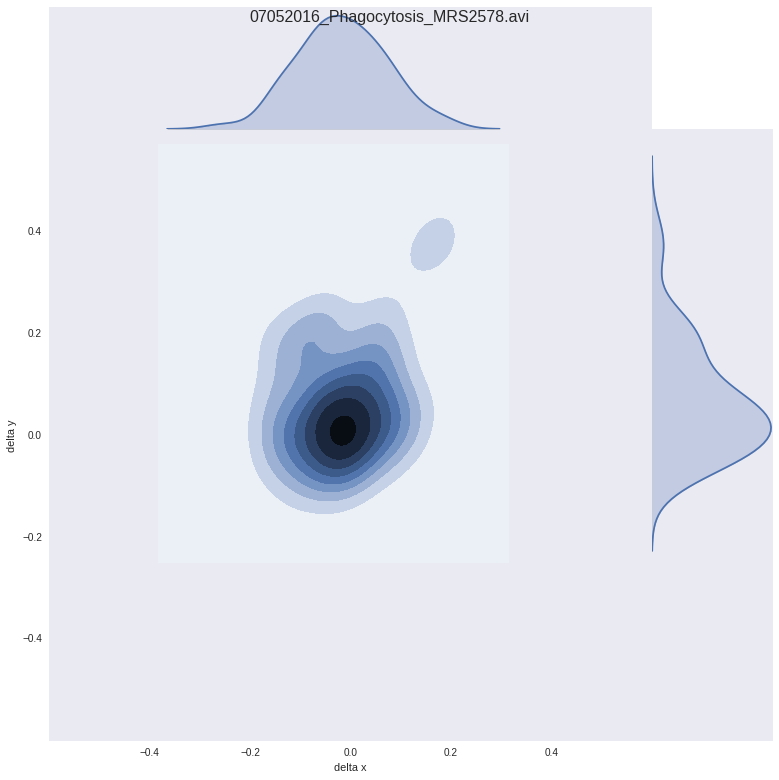

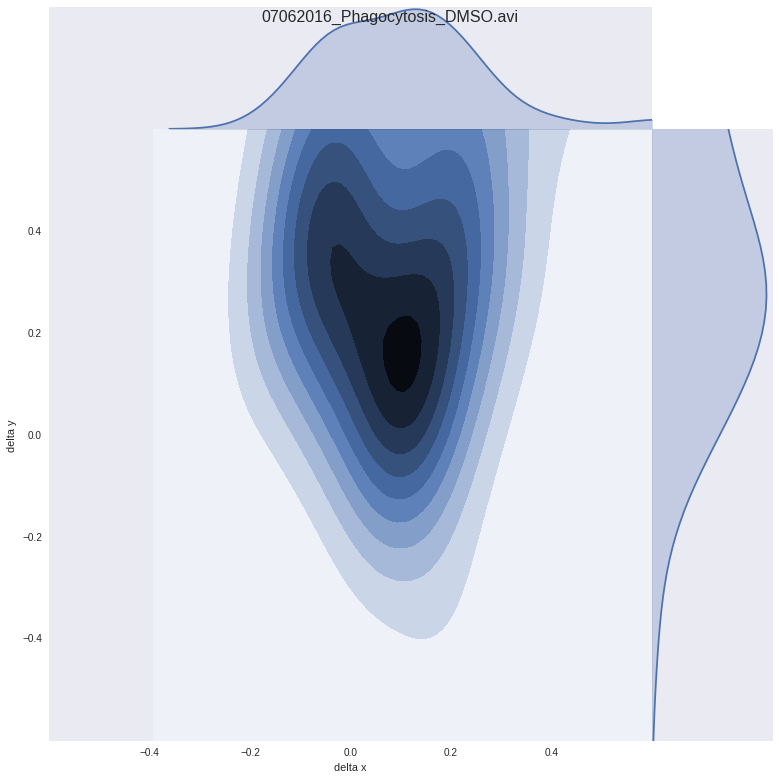

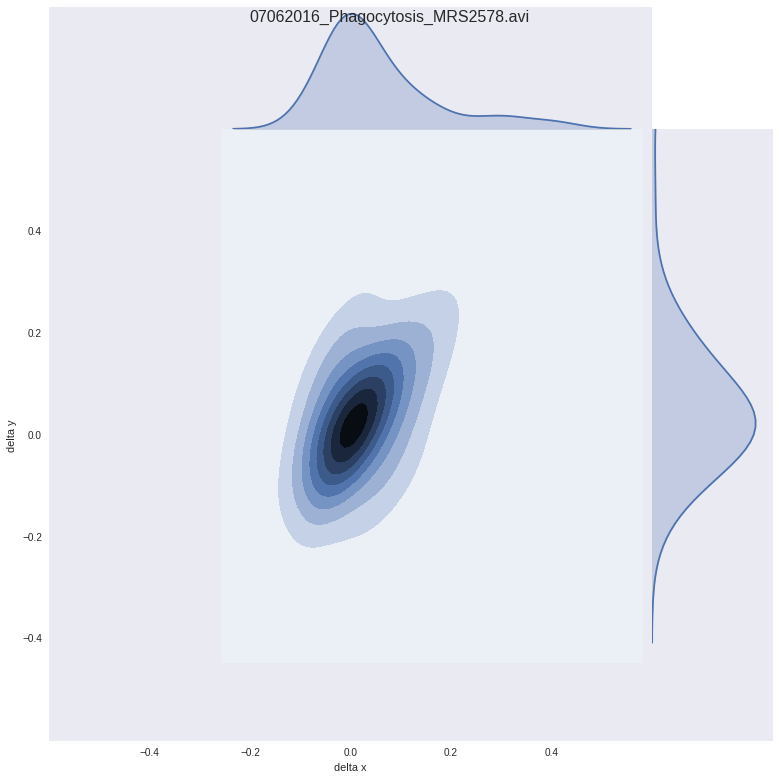

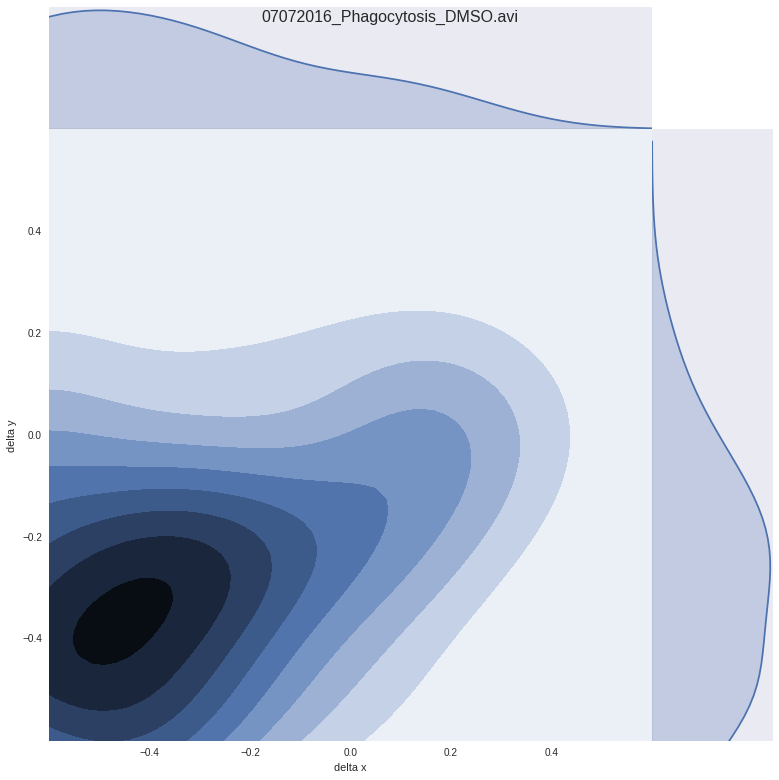

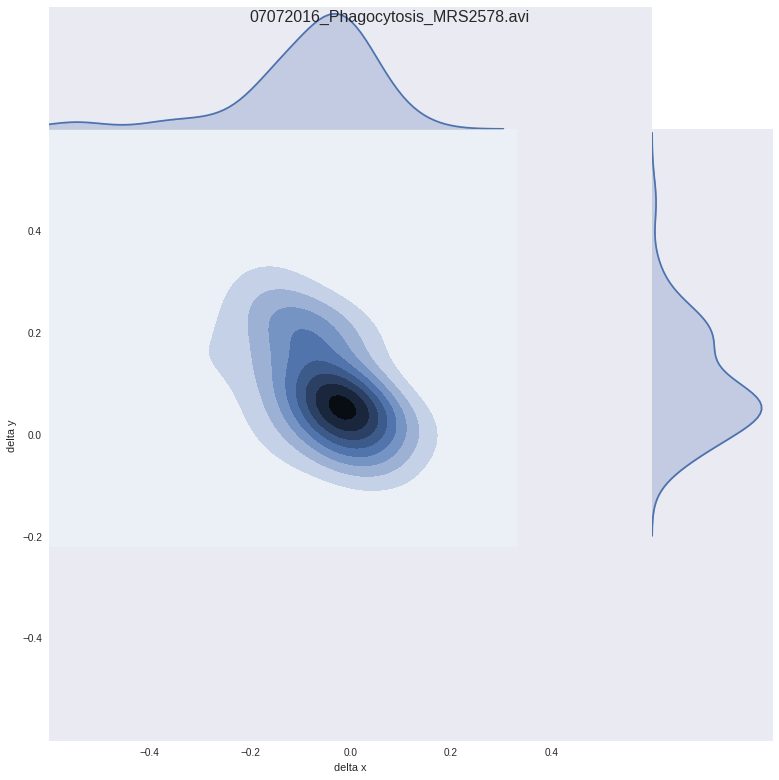

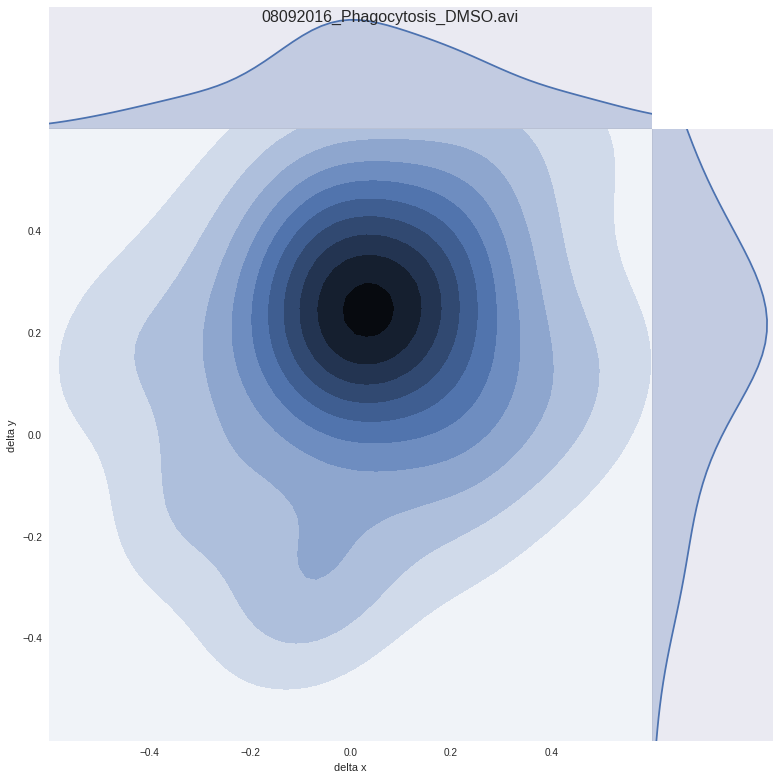

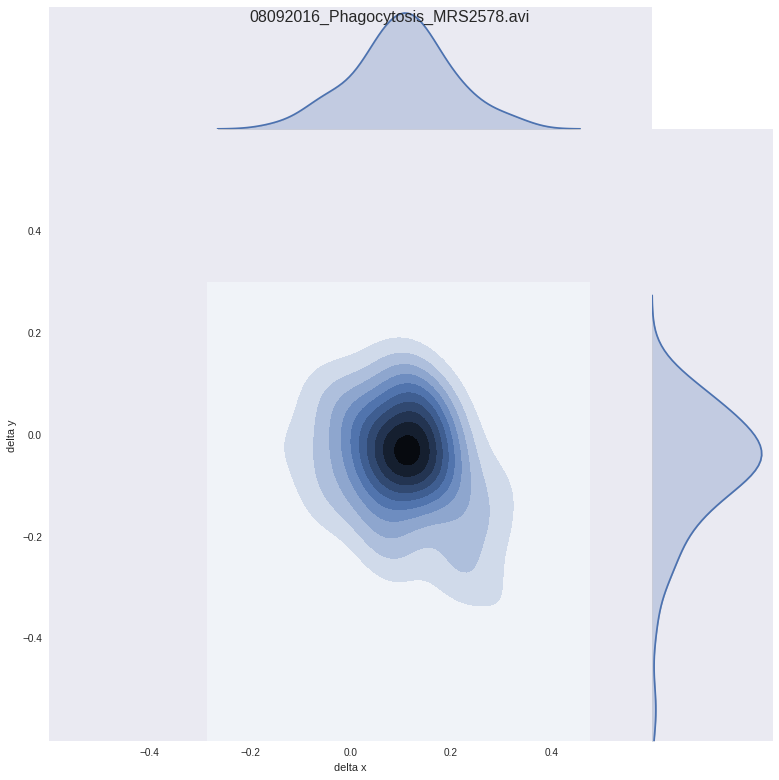

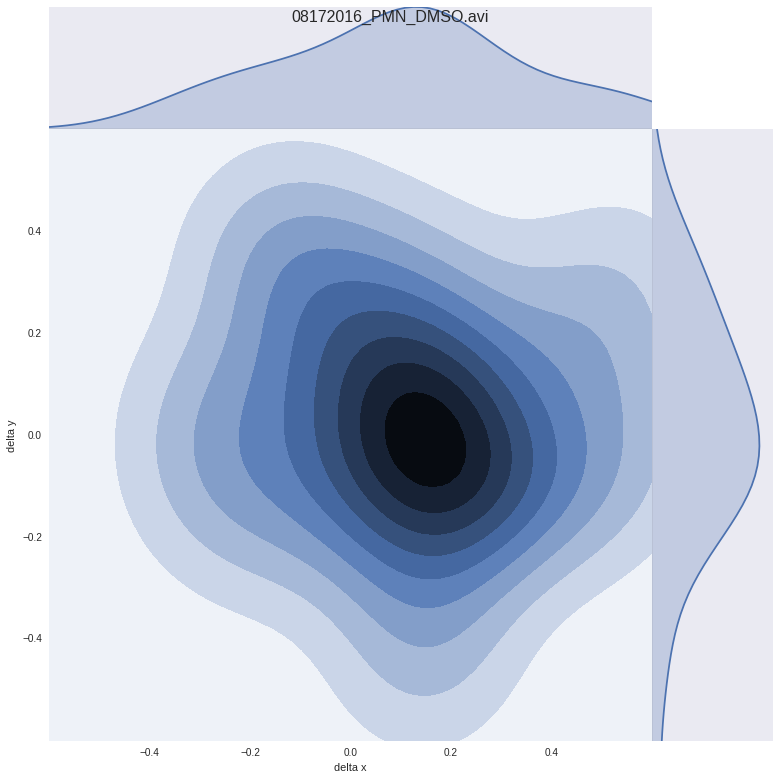

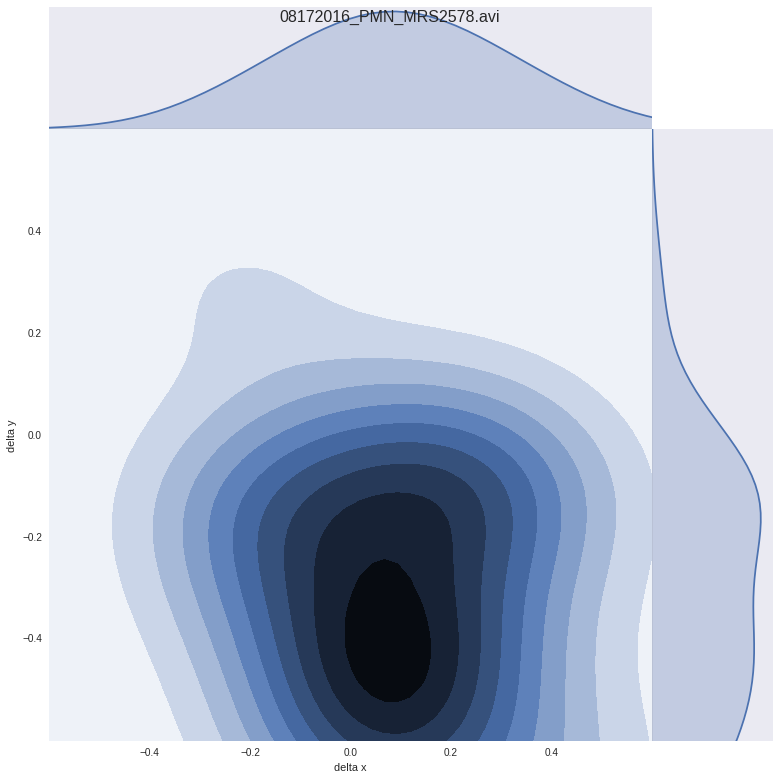

In [5]:
# plot one 2D histogram per video
sns.set(style="dark")

for i in range(len(xs)):
    x = pd.Series(np.array(xs[i]), name="delta x")
    y = pd.Series(np.array(ys[i]), name="delta y")
    title = fnames[i]
    g = sns.jointplot(x, y, kind="kde", stat_func=None, size=11, space=0, xlim=(-0.6, 0.6), ylim=(-0.6, 0.6))
    g.fig.suptitle(title, size=16)

In [6]:
fnames

['06302016_Phagocytosis_DMSO.avi',
 '06302016_Phagocytosis_Mrs2578.avi',
 '07052016_Phagocytosis_DMSO.avi',
 '07052016_Phagocytosis_MRS2578.avi',
 '07062016_Phagocytosis_DMSO.avi',
 '07062016_Phagocytosis_MRS2578.avi',
 '07072016_Phagocytosis_DMSO.avi',
 '07072016_Phagocytosis_MRS2578.avi',
 '08092016_Phagocytosis_DMSO.avi',
 '08092016_Phagocytosis_MRS2578.avi',
 '08172016_PMN_DMSO.avi',
 '08172016_PMN_MRS2578.avi']

## Final plots contour and gradient, black and white, all in one array and seperate

look in `contour_plots` and `gradient_plots`

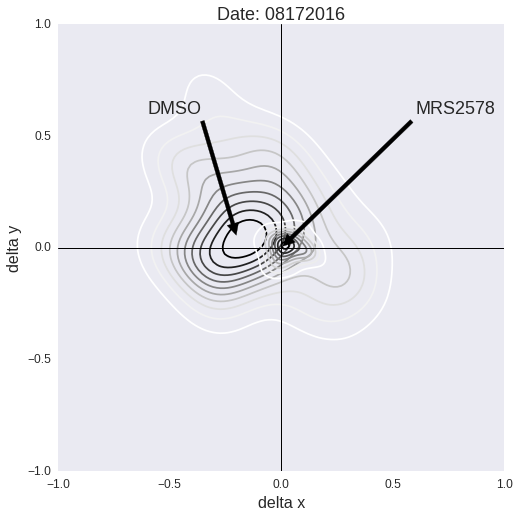

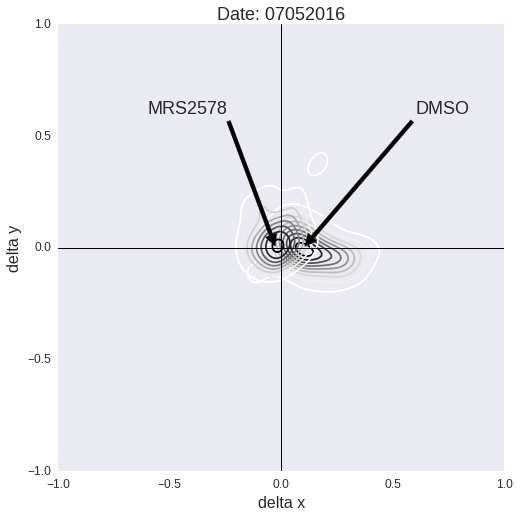

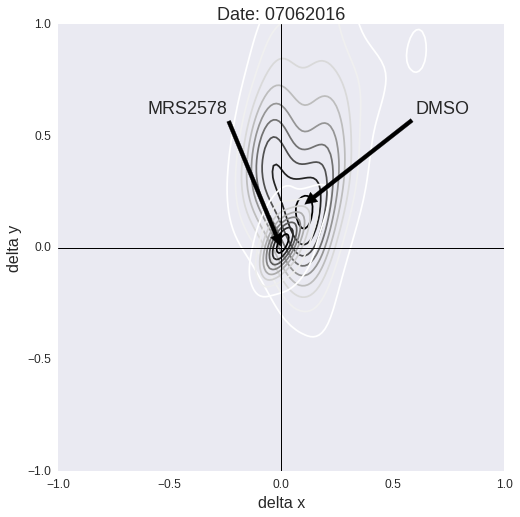

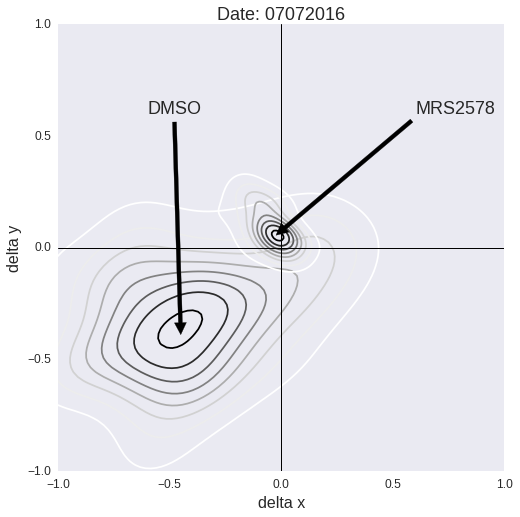

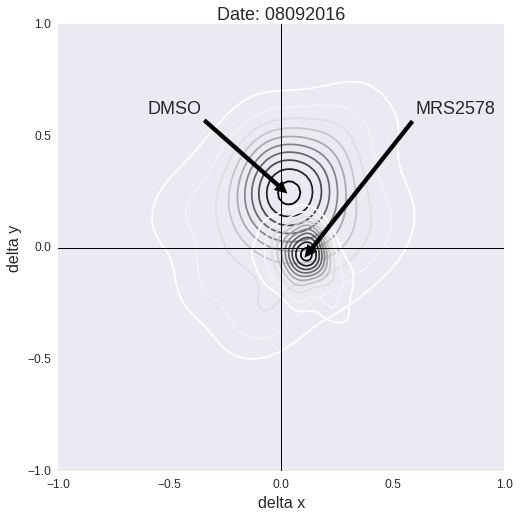

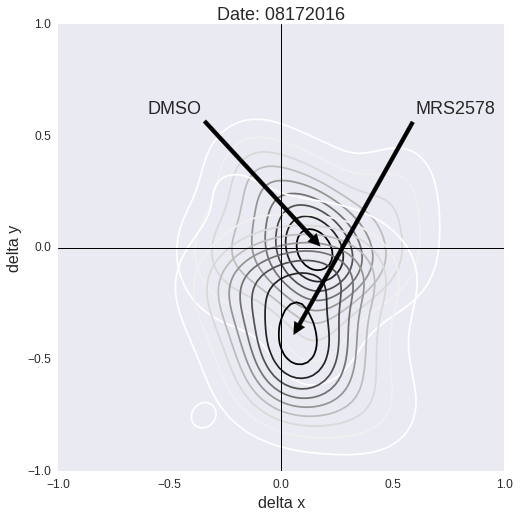

In [7]:
import seaborn

shade = False
# shade = True

title = "Date: " + fnames[i][:8]
save_dir = "contour_plots/"
# save_dir = "gradient_plots/"

axes = []

i=0
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(np.array(xs[i]), np.array(ys[i]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax = sns.kdeplot(np.array(xs[i+1]), np.array(ys[i+1]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title(title, size=18)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.annotate('DMSO', xy=(-0.2, 0.05), xytext=(-0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)

ax.annotate('MRS2578', xy=(0.0, 0.0), xytext=(0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)
f.savefig(save_dir + title + ".png", dpi=600)
axes.append(ax)

i=2
title = "Date: " + fnames[i][:8]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(np.array(xs[i]), np.array(ys[i]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax = sns.kdeplot(np.array(xs[i+1]), np.array(ys[i+1]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title(title, size=18)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.annotate('DMSO', xy=(0.1, 0.0), xytext=(0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)

ax.annotate('MRS2578', xy=(-0.025, 0.0), xytext=(-0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)
f.savefig(save_dir + title + ".png", dpi=600)
axes.append(ax)

i=4
title = "Date: " + fnames[i][:8]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(np.array(xs[i]), np.array(ys[i]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax = sns.kdeplot(np.array(xs[i+1]), np.array(ys[i+1]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title(title, size=18)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.annotate('DMSO', xy=(0.1, 0.19), xytext=(0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)

ax.annotate('MRS2578', xy=(0.0, 0.0), xytext=(-0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)
f.savefig(save_dir + title + ".png", dpi=600)
axes.append(ax)

i=6
title = "Date: " + fnames[i][:8]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(np.array(xs[i]), np.array(ys[i]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax = sns.kdeplot(np.array(xs[i+1]), np.array(ys[i+1]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title(title, size=18)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.annotate('DMSO', xy=(-0.45, -0.4), xytext=(-0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)

ax.annotate('MRS2578', xy=(-0.03, 0.05), xytext=(0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)
f.savefig(save_dir + title + ".png", dpi=600)
axes.append(ax)

i=8
title = "Date: " + fnames[i][:8]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(np.array(xs[i]), np.array(ys[i]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax = sns.kdeplot(np.array(xs[i+1]), np.array(ys[i+1]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title(title, size=18)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.annotate('DMSO', xy=(0.03, 0.24), xytext=(-0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)

ax.annotate('MRS2578', xy=(0.1, -0.05), xytext=(0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)
f.savefig(save_dir + title + ".png", dpi=600)
axes.append(ax)

i=10
title = "Date: " + fnames[i][:8]

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

ax = sns.kdeplot(np.array(xs[i]), np.array(ys[i]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax = sns.kdeplot(np.array(xs[i+1]), np.array(ys[i+1]), linestyles="solid",
                 cmap=None, shade=shade, shade_lowest=False)
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
ax.set_title(title, size=18)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.set_xlabel('delta x', fontsize=16)
ax.set_ylabel('delta y', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.annotate('DMSO', xy=(0.18, 0.0), xytext=(-0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)

ax.annotate('MRS2578', xy=(0.05, -0.4), xytext=(0.6, 0.6), size=18,
        arrowprops=dict(facecolor='black', shrink=0.01),
)
f.savefig(save_dir + title + ".png", dpi=600)
axes.append(ax)

## Plot mean, Stderr for each video together

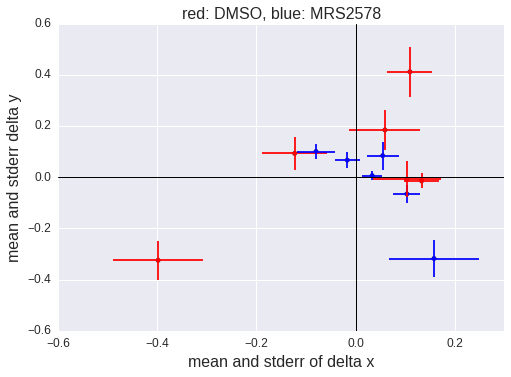

In [8]:
from imp import reload
import seaborn
reload(seaborn)
colors = ["red", "blue"] * 6

xmeans = [np.mean(x) for x in xs]
ymeans = [np.mean(y) for y in ys]
x_std_ers = [np.std(x) / np.sqrt(len(xs)) for x in xs]
y_std_ers = [np.std(y) / np.sqrt(len(ys)) for y in ys]

f, ax = plt.subplots()
ax.scatter(xmeans,ymeans, c=colors)
ax.set_title("red: DMSO, blue: MRS2578", size=16)
ax.set_xlabel('mean and stderr of delta x', fontsize=16)
ax.set_ylabel('mean and stderr delta y', fontsize=16)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=12)

for i in range(len(xmeans)):

    plt.errorbar(xmeans[i],ymeans[i],xerr=x_std_ers[i], ecolor=colors[i], linestyle="None")
    plt.errorbar(xmeans[i],ymeans[i],yerr=y_std_ers[i], ecolor=colors[i], linestyle="None")

plt.show()

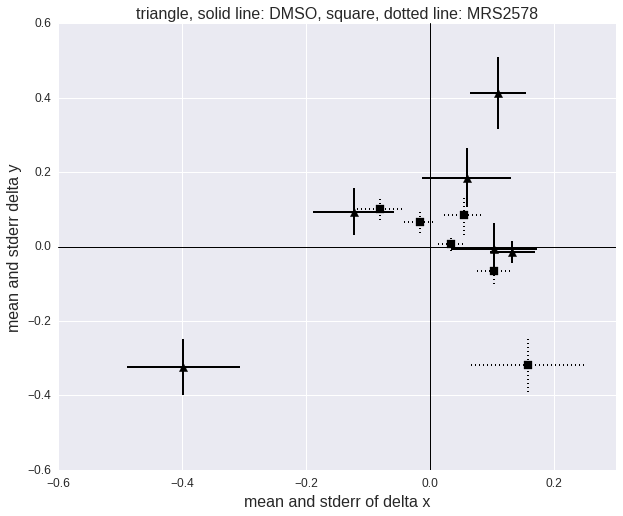

In [9]:
from imp import reload
import seaborn
reload(seaborn)
linestyle = ["solid", "dotted"] * 6

xmeans = [np.mean(x) for x in xs]
ymeans = [np.mean(y) for y in ys]
x_std_ers = [np.std(x) / np.sqrt(len(xs)) for x in xs]
y_std_ers = [np.std(y) / np.sqrt(len(ys)) for y in ys]

f, ax = plt.subplots(figsize=(10, 8))
DMSO_xmeans = [xmeans[i] for i in range(0,12,2)]
DMSO_ymeans = [ymeans[i] for i in range(0,12,2)]
MRS2578_xmeans = [xmeans[i] for i in range(1,12,2)]
MRS2578_ymeans = [ymeans[i] for i in range(1,12,2)]

ax.scatter(DMSO_xmeans,DMSO_ymeans, c="black", marker="^", s=70)
ax.scatter(MRS2578_xmeans,MRS2578_ymeans, c="black", marker="s", s=70)

ax.set_title("triangle, solid line: DMSO, square, dotted line: MRS2578", size=16)
ax.set_xlabel('mean and stderr of delta x', fontsize=16)
ax.set_ylabel('mean and stderr delta y', fontsize=16)
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
ax.tick_params(axis='both', which='major', labelsize=12)

for i in range(len(xmeans)):
    # remove duplicates
        
    eb1=plt.errorbar(xmeans[i],ymeans[i],xerr=x_std_ers[i], lw=2, color="black", elinewidth=2)
    eb1[-1][0].set_linestyle(linestyle[i])
    
    eb2=plt.errorbar(xmeans[i],ymeans[i],yerr=y_std_ers[i], lw=2, color="black", elinewidth=2)
    eb2[-1][0].set_linestyle(linestyle[i])

plt.show()
f.savefig("histograms/combined_black_and_white.png")

In [54]:

# hmm... some frames are missing from some vieos??
# for elem in xs:
#     length = len(elem)
#     elem += [0] * (60-length)
#     print(length)
    
# for elem in ys:
#     length = len(elem)
#     elem += [0] * (60-length)
#     print(length)
    
x_means = np.array(xs).mean(axis=1)
x_stds = np.array(xs).std(axis=1)
y_means = np.array(ys).mean(axis=1)
y_stds = np.array(ys).std(axis=1)

pd.DataFrame(data=np.column_stack((np.array(fnames), x_means, x_stds, y_means, y_stds)),
            columns=["filenames", "x_means", "x_stdevs", "y_means", "y_stdevs"])

,filenames,x_means,x_stdevs,y_means,y_stdevs
0,06302016_Phagocytosis_DMSO.avi,-0.09221834658334653,0.20287484849582416,0.07038929676249002,0.19433324206605743
1,06302016_Phagocytosis_Mrs2578.avi,0.02489097270105655,0.06342296663024821,0.004950657630494485,0.056522211191643655
2,07052016_Phagocytosis_DMSO.avi,0.132891098188702,0.12490621362633748,-0.013862156037551662,0.10152135225649186
3,07052016_Phagocytosis_MRS2578.avi,-0.017050844601665935,0.08663644948137147,0.06741218059711779,0.1099870857906645
4,07062016_Phagocytosis_DMSO.avi,0.10934977381257341,0.15704221188458542,0.41266628404458366,0.33760020602206336
5,07062016_Phagocytosis_MRS2578.avi,0.054507742502028125,0.11255391666593585,0.08474462931820502,0.18749272337041312
6,07072016_Phagocytosis_DMSO.avi,-0.39831926432282977,0.3156896287799099,-0.324077722725148,0.26129960699756893
7,07072016_Phagocytosis_MRS2578.avi,-0.08002781531540677,0.1303343586496251,0.10094007994048297,0.10202891870745297
8,08092016_Phagocytosis_DMSO.avi,0.05896738286440571,0.24817673429616646,0.18524665328053136,0.2764175570055951
9,08092016_Phagocytosis_MRS2578.avi,0.10324695375917751,0.09490876541163988,-0.06480595790781081,0.1193181253753977
